# Predicting Energy Efficiency With Regression

In [1]:
# Please load packages before continuing:
library(tidyverse)
library(readxl)
library(repr) # for visualization
library(tidymodels)
library(cowplot)
library(GGally)
options(repr.matrix.max.rows = 6)
set.seed(2020)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## 1. Introduction

**1.1. Background Information**

The heating load of a building is "the amount of heat energy" needed "to maintain the temperature in an acceptable range" (Government of Australia).
A higher heating load correlates to more heat energy required, which is detrimental to the environment, and has a higher monetary cost. In fact, an MIT study has found that "energy consumption in the buildings sector accounts for 25 to 30 percent of global carbon dioxide emissions" (Urban & Glicksman).
We aim to study how various factors such as surface area, overall height, and glazing area (ie. amount of glass) affects the heating load of buildings. We define more energy-efficient buildings as buildings that require lower heating loads.

**1.2. Question**

What is the heating load (energy-efficiency) for a building with a given surface area, overall height, and glazing area?

**1.3. Dataset Description**

We're using the "Energy Efficiency Data Set" created at the University of Oxford (Xifara & Tsanas).
It contains eight attributes and two outcomes which are shown in the dataset dictionary below (Table 1.3). Initially, all columns were labelled X1, X2, etc. instead of their corresponding descriptive names. The dataset has 768 rows and was generated through computer simulation. All observations (buildings) have the same volume, thus we can evaluate the effect of predictors independent of volume.

Dataset dictionary:  
Some units have been omitted as the dataset does not provide units for all variables.

| ID  | Name                      | Definition                                                                                                          |
|-----|---------------------------|---------------------------------------------------------------------------------------------------------------------|
| X1  | Relative Compactness      | Sum of all surfaces of the building divided by its gross heated volume                                              |
| X2  | Surface Area (m^2)        | Sum of all surfaces of the building                                                                                 |
| X3  | Wall Area (m^2)           | Sum of all surfaces of the building walls                                                                           |
| X4  | Roof Area (m^2)           | Sum of all surfaces of the building roofs                                                                           |
| X5  | Overall Height (m)        | Height of the building                                                                                              |
| X6  | Orientation               | Cardinal direction                                                                                                  |
| X7  | Glazing Area (m^2)        | Size of all windows combined                                                                                        |
| X8  | Glazing Area Distribution | Distribution of glazing area                                                                                        |
| y1  | Heating Load              | Amount of heat energy that would need to be added to a space to maintain the temperature in an acceptable range     |
| y2 | Cooling Load              | Amount of heat energy that would need to be removed from a space to maintain the temperature in an acceptable range |




<div style="color:#999999; text-align: center; font-size:15px; font-family: Arial, sans-serif;">
Table 1.3: Dataset dictionary.
</div>


## 2. Method and Process

We first read the dataset into R and tidied the dataset by adding column names. In the dataset, the provided column names aren’t descriptive (X1, X2 and so on) so we changed the names to what the columns represent. 

We are choosing to predict Heating Load because it is more relevant to Vancouver as we tend to need to keep buildings warm during the cold winters rather than cool buildings during summer.

The next step is selecting the predictors we will use for our analysis. We chose to use Surface Area, Overall Height, and Glazing Area as we believe they would have the most affect on the Heating Load of the buildings. We chose not to use Relative Compactness as it is not clear what Relative Compactness represents. We chose not to use the Roof Area and Wall Area as it is encompassed within the Surface Area measurement. We chose not to use Orientation as it is a categorical variable and therefore would have too strong of an influence on the regression analysis. Finally, we did not choose Glazing Area Distribution as it is similar to Glazing Area so only one of the two columns is needed in the analysis. Since the distribution of Glazing Area is dependent on Glazing Area, we chose not to include Glazing Area distribution in our analysis.

Next, we split our data into 75% training data and 25% testing data so we can evaluate our models with data not used in training. Before building the models, we summarized the data and visualized their relationship with Heating Load to be able to make a hypothesis on which type of regression will predict more accurately.

For K-NN regression, we tuned the classifier, performing a 5 fold cross validation in order to obtain a better estimate of accuracy for each value of K. We chose to tune for K values up to 20 as due to the size of our model, any K value larger than 20 would be underfitting the data so we don’t need to test those K values. We can then obtain the best K value and build our K-NN classifier using that K. 
For linear regression, tuning is not needed, so we build our linear classifier and obtain the linear regression formula to determine the influence of each predictor.

For both K-NN and linear regression, we predict the Heating Load of the testing data and take metrics on the predicted data to calculate the RMSPE of each model. We use both the RMSPE and visualizations of the Predicted Heating Load vs Actual Heating Load to compare the two models and determine the outcome of our analysis.

## 3. Preliminary Exploratory Data Analysis

**3.1. Reading Data Set into R and Tidying (changing column names)**

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
file_name <- "energy-efficiency.xlsx"
download.file(url, file_name)
energy_data <- read_excel(file_name, 
                          skip = 1, 
                          col_names = c("Relative.Compactness", "Surface.Area", "Wall.Area", 
                                        "Roof.Area", "Overall.Height", "Orientation", 
                                        "Glazing.Area", "Glazing.Area.Distribution", 
                                        "Heating.Load", "Cooling.Load"))
energy_data

Relative.Compactness,Surface.Area,Wall.Area,Roof.Area,Overall.Height,Orientation,Glazing.Area,Glazing.Area.Distribution,Heating.Load,Cooling.Load
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.98,514.5,294,110.25,7,2,0,0,15.55,21.33
0.98,514.5,294,110.25,7,3,0,0,15.55,21.33
0.98,514.5,294,110.25,7,4,0,0,15.55,21.33
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.62,808.5,367.5,220.5,3.5,3,0.4,5,16.44,17.11
0.62,808.5,367.5,220.5,3.5,4,0.4,5,16.48,16.61
0.62,808.5,367.5,220.5,3.5,5,0.4,5,16.64,16.03


<div style="color:#999999; text-align: center; font-size:15px; font-family: Arial, sans-serif;">
Table 3.1: Overview of original data frame.
</div>

**3.2. Cleaning and Wrangling Data**

In [3]:
# Table with variables that we will be using in our analysis
energy_data_reduced <- energy_data |>
                    select(Surface.Area, Overall.Height, Glazing.Area, Heating.Load)
energy_data_reduced

Surface.Area,Overall.Height,Glazing.Area,Heating.Load
<dbl>,<dbl>,<dbl>,<dbl>
514.5,7,0,15.55
514.5,7,0,15.55
514.5,7,0,15.55
⋮,⋮,⋮,⋮
808.5,3.5,0.4,16.44
808.5,3.5,0.4,16.48
808.5,3.5,0.4,16.64


<div style="color:#999999; font-size:15px; font-family: Arial, sans-serif;">
Table 3.2: Overview of reduced data frame that will be used in analysis.
</div>

In [4]:
energy_split <- initial_split(energy_data_reduced, prop = 0.75, strata = Heating.Load)
energy_train <- training(energy_split)
energy_test <- testing(energy_split)

**3.3. Data Summarization (only training data)**

In [5]:
# Mean Table
energy_data_mean <- summarize(energy_train,
    Surface.Area.Mean = mean(Surface.Area),                   
    Overall.Height.Mean = mean(Overall.Height),                        
    Glazing.Area.Mean = mean(Glazing.Area),                            
    Heating.Load.Mean = mean(Heating.Load))
energy_data_mean

Surface.Area.Mean,Overall.Height.Mean,Glazing.Area.Mean,Heating.Load.Mean
<dbl>,<dbl>,<dbl>,<dbl>
672.5165,5.243924,0.2347222,22.3232


<div style="color:#999999; font-size:15px; font-family: Arial, sans-serif;">
Table 3.3.1: Table of the means.
</div>

In [6]:
# Median Table
energy_data_median <- summarize(energy_train,
    Surface.Area.Median = median(Surface.Area),                   
    Overall.Height.Median = median(Overall.Height),                        
    Glazing.Area.Median = median(Glazing.Area),  
    Heating.Load.Median = median(Heating.Load))
energy_data_median

Surface.Area.Median,Overall.Height.Median,Glazing.Area.Median,Heating.Load.Median
<dbl>,<dbl>,<dbl>,<dbl>
686,3.5,0.25,18.95


<div style="color:#999999; font-size:15px; font-family: Arial, sans-serif;">
Table 3.3.2: Table of the medians.
</div>

In [7]:
# Finding Mode
heating_mode <- names(sort(-table(energy_train$Heating.Load)))[1]
surface_mode <- names(sort(-table(energy_train$Surface.Area)))[1]
height_mode <- names(sort(-table(energy_train$Overall.Height)))[1]
glazing_mode <- names(sort(-table(energy_train$Glazing.Area)))[1]

# Mode Table
energy_data_mode <- summarize(energy_train,
                        Surface.Area.Mode = surface_mode,
                        Overall.Height.Mode = height_mode,
                        Glazing.Area.Mode = glazing_mode,
                        Heating.Load.Mode = heating_mode)
energy_data_mode

Surface.Area.Mode,Overall.Height.Mode,Glazing.Area.Mode,Heating.Load.Mode
<chr>,<chr>,<chr>,<chr>
808.5,3.5,0.25,15.16


<div style="color:#999999; font-size:15px; font-family: Arial, sans-serif;">
Table 3.3.3: Table of the modes.
</div>

In [8]:
# Max Table
energy_data_max <- summarize(energy_train,
    Surface.Area.Max = max(Surface.Area),                   
    Overall.Height.Max = max(Overall.Height),                        
    Glazing.Area.Max = max(Glazing.Area),  
    Heating.Load.Max = max(Heating.Load))
energy_data_max

Surface.Area.Max,Overall.Height.Max,Glazing.Area.Max,Heating.Load.Max
<dbl>,<dbl>,<dbl>,<dbl>
808.5,7,0.4,42.77


<div style="color:#999999; font-size:15px; font-family: Arial, sans-serif;">
Table 3.3.4: Table of the maxes.
</div>

In [9]:
# Min Table
energy_data_min <- summarize(energy_train,
    Surface.Area.Min = min(Surface.Area),                   
    Overall.Height.Min = min(Overall.Height),                        
    Glazing.Area.Min = min(Glazing.Area),  
    Heating.Load.Min = min(Heating.Load))
energy_data_min

Surface.Area.Min,Overall.Height.Min,Glazing.Area.Min,Heating.Load.Min
<dbl>,<dbl>,<dbl>,<dbl>
514.5,3.5,0,6.01


<div style="color:#999999; font-size:15px; font-family: Arial, sans-serif;">
Table 3.3.5: Table of the mins.
</div>

In [10]:
# Number of Rows Missing Data
num_rows_missing_data <- energy_train |>
                        filter(Surface.Area == NA | 
                               Overall.Height == NA | Glazing.Area == NA | Heating.Load == NA) |>
                        nrow() |>
                        as_tibble()
colnames(num_rows_missing_data) <- c("Number.Of.Rows.Missing.Data")
num_rows_missing_data

Number.Of.Rows.Missing.Data
<int>
0


<div style="color:#999999; font-size:15px; font-family: Arial, sans-serif;">
Table 3.3.6: Number of rows missing data.
</div>

**3.4. Initial Data Visualization (only training data)**

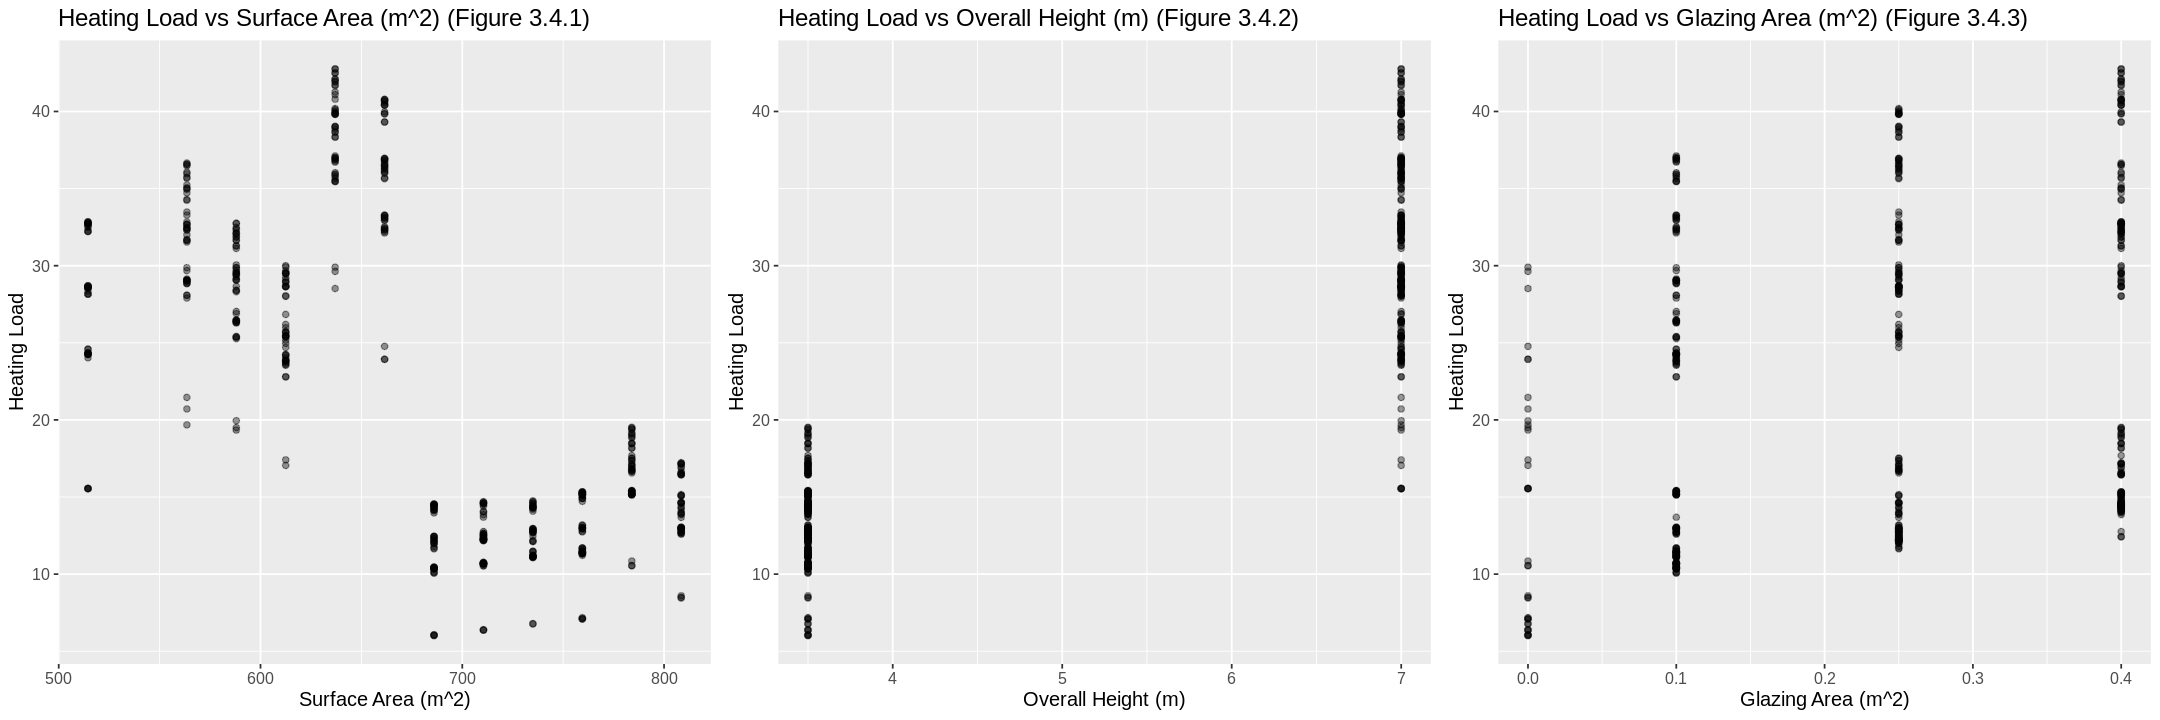

In [11]:
# Some units have been omitted as our dataset did not provide units for all variables.
options(repr.plot.width=18, repr.plot.height=6)
plot_surface <- ggplot(energy_train, aes(x = Surface.Area, y = Heating.Load)) +
    geom_point(alpha = 0.4) +
    labs(x = "Surface Area (m^2)", y = "Heating Load") +
    theme(text = element_text(size = 12)) +
    ggtitle("Heating Load vs Surface Area (m^2) (Figure 3.4.1)")
plot_height <- ggplot(energy_train, aes(x = Overall.Height, y = Heating.Load)) +
    geom_point(alpha = 0.4) +
    labs(x = "Overall Height (m)", y = "Heating Load") +
    theme(text = element_text(size = 12)) +
    ggtitle("Heating Load vs Overall Height (m) (Figure 3.4.2)")
plot_glazing <- ggplot(energy_train, aes(x = Glazing.Area, y = Heating.Load)) +
    geom_point(alpha = 0.4) +
    labs(x = "Glazing Area (m^2)", y = "Heating Load") +
    theme(text = element_text(size = 12)) +
    ggtitle("Heating Load vs Glazing Area (m^2) (Figure 3.4.3)")
plot_grid(plot_surface, plot_height, plot_glazing, nrow = 1)

<div style="color:#999999; text-align: center; font-size:15px; font-family: Arial, sans-serif;">
Figures 3.4.1, 3.4.2, and 3.4.3: Initial visualization of training data (relationships between predictor variables and target variable, Heating Load).
</div>

**3.5. Interpretation of Visualizations**

Plot 3.4.1 doesn’t show a continuous linear pattern. The relationship changes from negative to positive around the middle, where the Heating Load drops and starts to increase more gradually. This change may indicate a more energy-efficient Surface Area around its median, whereas considering the jumps at ~635 m^2, and ~785 m^2 (where afterwards the relationship changes direction), it could also mean that other predictor variables are having an effect on Heating Load.

Plots 3.4.2 and 3.4.3 show that both Overall Height and Glazing Area have a positive linear relationship with Heating Load. Differently from Overall Height, when Glazing Area is 0 m^2, the Heating Load is distributed across a wider range, thus at 0 m^2, the other predictor variables may have a greater effect on Heating Load. In most of our visualizations, the Heating Load values are widely distributed for a single predictor variable value, which could mean that other variables are having an effect.

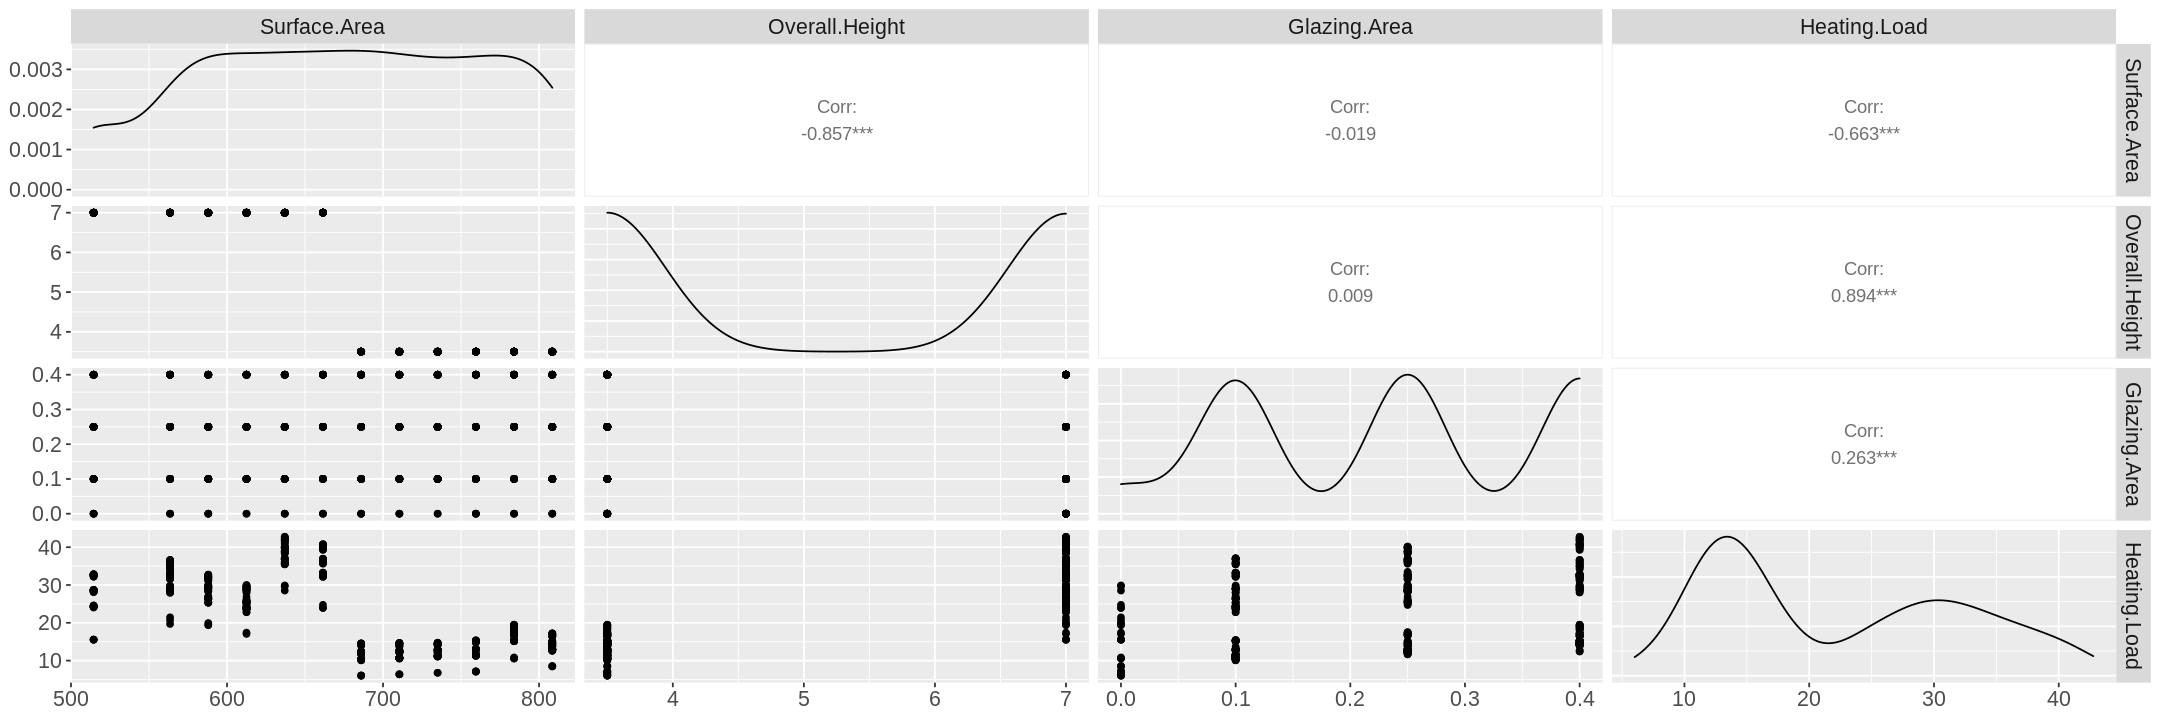

In [12]:
lm_plot <- ggpairs(energy_train) +
           theme(text = element_text(size = 16))
lm_plot

<div style="color:#999999; text-align: center; font-size:15px; font-family: Arial, sans-serif;">
Table 3.5: Relationships between each variable we used.
</div>

**3.6. Expected Outcomes**

From our initial visualizations, we expect the Heating Load to be proportional to Overall Height and Glazing Area. The visualizations also suggest that there may be a weaker relationship between Surface Area and Heating Load so Glazing Area and Overall Height will influence the model more. We also expect a model using K-NN regression to be more accurate in predicting Heating Load than a linear regression model because our visualizations do not suggest a strong linear relationship.

## 4. Data Analysis

**4.1. Analysis Using K-NN Regression**

In [13]:
# Recipe
data_recipe <- recipe(Heating.Load ~ Surface.Area + Overall.Height + Glazing.Area, 
                      data = energy_train) |>                                    
                      step_scale(all_predictors()) |>
                      step_center(all_predictors())

In [14]:
# Tuning and Performing 5-Fold Cross Validation
data_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("regression") 

data_vfold <- vfold_cv(energy_train, v = 5, strata = Heating.Load)

data_workflow <- workflow() |>
    add_recipe(data_recipe) |>
    add_model(data_spec)

gridvals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

data_results <- data_workflow |>
  tune_grid(resamples = data_vfold, grid = gridvals) |>
  collect_metrics()

data_results_sorted <- data_results |>
    filter(.metric == "rmse") |>
    arrange(mean)

data_results_sorted

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
4,rmse,standard,0.7351523,5,0.05947831,Preprocessor1_Model04
2,rmse,standard,0.7384156,5,0.08201573,Preprocessor1_Model02
1,rmse,standard,0.7402031,5,0.06425753,Preprocessor1_Model01
⋮,⋮,⋮,⋮,⋮,⋮,⋮
18,rmse,standard,2.137246,5,0.1586372,Preprocessor1_Model18
19,rmse,standard,2.272151,5,0.1745431,Preprocessor1_Model19
20,rmse,standard,2.342002,5,0.2291846,Preprocessor1_Model20


<div style="color:#999999; font-size:15px; font-family: Arial, sans-serif;">
Table 4.1.1: Number of neighbors sorted by RMSE in increasing order.
</div>

In [15]:
# Finding Best K (Minimum RMSE)
data_min <- data_results_sorted |> 
            head(n=1)

k_min <- data_min |>
         pull(neighbors)

cat("Best K: ", k_min)

Best K:  4

<div style="color:#999999; font-size:15px; font-family: Arial, sans-serif;">
Figure 4.1.2: Best K Value.
</div>

In [16]:
# K-NN Regression with Best K
data_best_spec <- nearest_neighbor(weight_func = "rectangular", 
                                   neighbors = k_min) |>
          set_engine("kknn") |>
          set_mode("regression")

data_fit <- workflow() |>
          add_recipe(data_recipe) |>
          add_model(data_best_spec) |>
          fit(data = energy_train)

data_predictions <- data_fit |>
           predict(energy_test) |>
           bind_cols(energy_test) 
data_predictions

.pred,Surface.Area,Overall.Height,Glazing.Area,Heating.Load
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20.3375,563.5,7,0,20.84
18.9600,588.0,7,0,18.31
18.4375,612.5,7,0,16.95
⋮,⋮,⋮,⋮,⋮
14.4475,735.0,3.5,0.4,14.12
15.2575,759.5,3.5,0.4,14.96
18.5000,784.0,3.5,0.4,17.88


<div style="color:#999999; font-size:15px; font-family: Arial, sans-serif;">
Table 4.1.3: Prediction results of testing data using K-NN regression.
</div>

In [17]:
data_summary <- data_predictions |>
           metrics(truth = Heating.Load, estimate = .pred) |>
           filter(.metric == "rmse")

data_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.6320054


<div style="color:#999999; font-size:15px; font-family: Arial, sans-serif;">
Table 4.1.4: RMSPE of prediction using K-NN regression.
</div>

In [18]:
# RMSPE of K-NN Regression with Best K:

rmspe_knn <- data_summary |>
            select(.estimate) |>
            pull()
rmspe_knn

[1] 0.6320054

<div style="color:#999999; font-size:15px; font-family: Arial, sans-serif;">
Figure 4.1.5: RMPSE of the Best K.
</div>

**4.2. Analysis Using Linear Regression**

In [19]:
# Recipe and Fit
lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

lm_recipe <- recipe(Heating.Load ~ Surface.Area + Overall.Height + Glazing.Area, data = energy_train)
             
lm_fit <- workflow() |>
    add_recipe(lm_recipe) |>
    add_model(lm_spec) |>
    fit(data = energy_train)

lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
   (Intercept)    Surface.Area  Overall.Height    Glazing.Area  
     -50.77542         0.04621         7.12933        19.75534  


<div style="color:#999999; font-size:15px; font-family: Arial, sans-serif;">
Figure 4.2.1: Linear Regression Workflow.
</div>

In [20]:
# Testing Data Results (RMSPE)
lm_predictions <- lm_fit |>
    predict(energy_test) |>
    bind_cols(energy_test)

lm_predictions

.pred,Surface.Area,Overall.Height,Glazing.Area,Heating.Load
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
25.16835,563.5,7,0,20.84
26.30046,588.0,7,0,18.31
27.43257,612.5,7,0,16.95
⋮,⋮,⋮,⋮,⋮
16.04258,735.0,3.5,0.4,14.12
17.17469,759.5,3.5,0.4,14.96
18.30679,784.0,3.5,0.4,17.88


<div style="color:#999999; font-size:15px; font-family: Arial, sans-serif;">
Table 4.2.2: Prediction results of testing data using linear regression.
</div>

In [21]:
lm_test_results <- lm_predictions |>
    metrics(truth = Heating.Load, estimate = .pred) |>
    filter(.metric == "rmse")
lm_test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3.129638


<div style="color:#999999; font-size:15px; font-family: Arial, sans-serif;">
Table 4.2.3: RMSPE of prediction using linear regression.
</div>

In [22]:
# RMSPE of Linear Regression:
rmspe_lm <- lm_test_results |>
                select(.estimate) |>
                pull()
rmspe_lm

[1] 3.129638

<div style="color:#999999; font-size:15px; font-family: Arial, sans-serif;">
Figure 4.2.4: RMPSE of Linear Regression.
</div>

In [23]:
# Coefficients
lm_coefficients <- lm_fit |>
                   extract_fit_parsnip() |>
                   tidy()
lm_coefficients

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-50.77541765,2.609571906,-19.45737,4.276632e-65
Surface.Area,0.04620844,0.002853569,16.19321,7.974709e-49
Overall.Height,7.12933051,0.143179121,49.79309,4.153705e-210
Glazing.Area,19.75533768,0.971004706,20.34525,1.218531e-69


<div style="color:#999999; font-size:15px; font-family: Arial, sans-serif;">
Table 4.2.5: Coefficients and other statistics of linear regression model.
</div>

**Linear Regression Equation (Predicted Line of Best Fit):**

$Heating \ Load = -50.775 + 0.046 * (Surface Area) + 7.129 * (Overall Height) + 19.755 * (Glazing Area)$

**4.3. Visualizations**

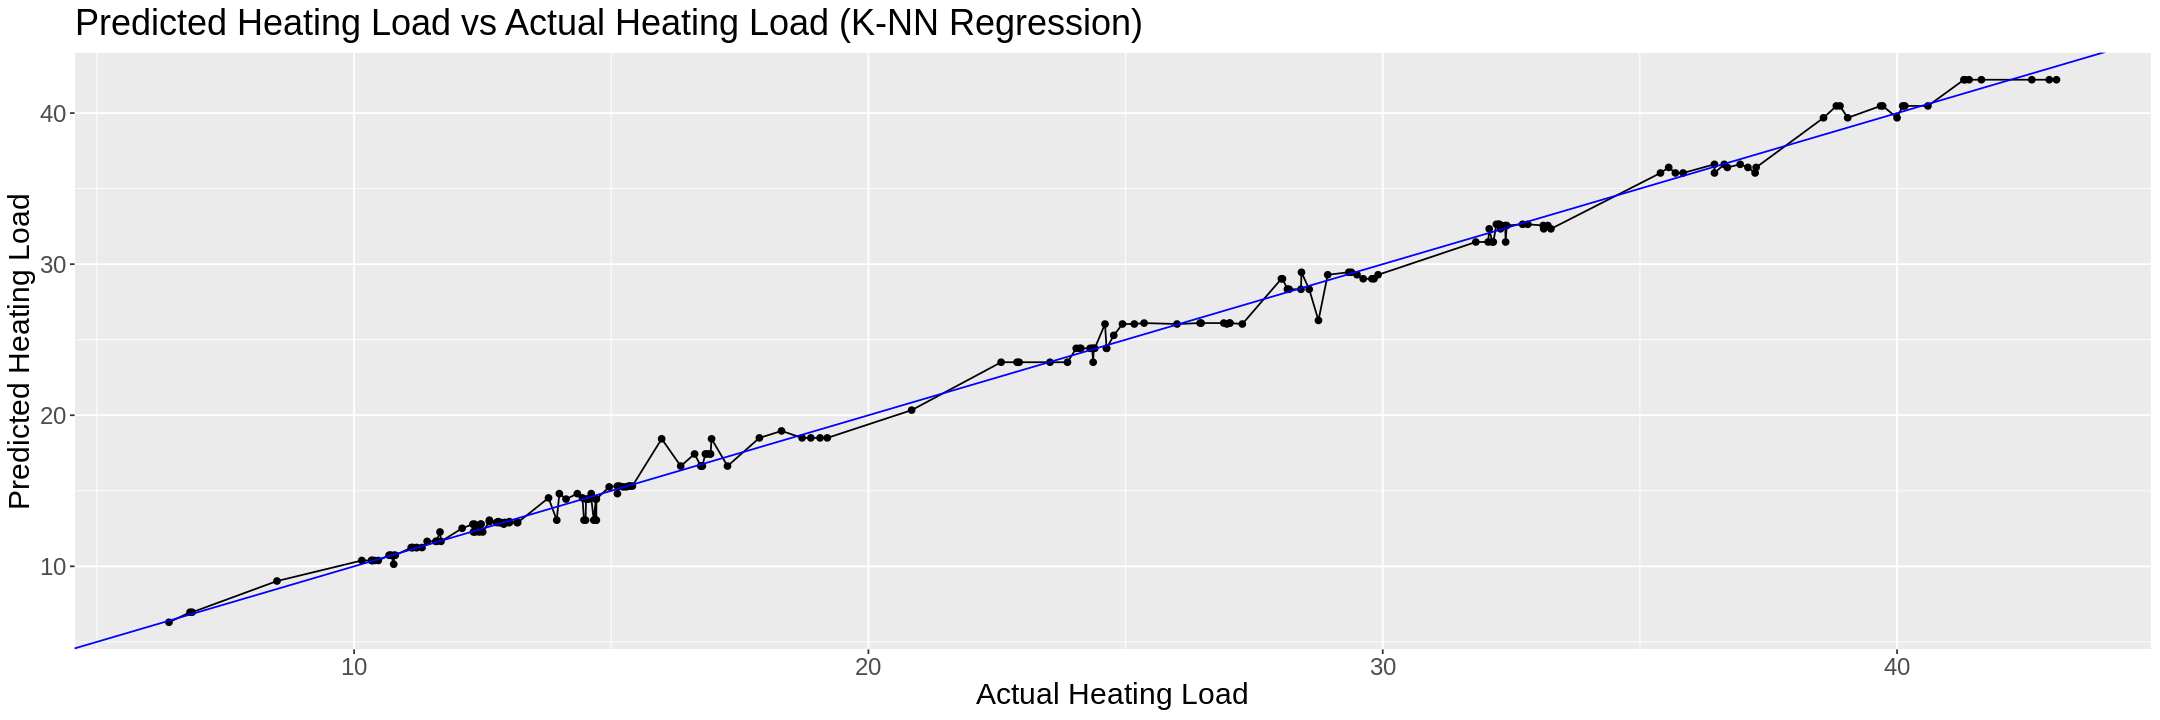

In [24]:
# Visualization of K-NN Regression model
predicted_vs_actual_knn_plot <- data_predictions |>
    ggplot(aes(x = Heating.Load, y = .pred)) +
    geom_point() +
    geom_line() +
    geom_abline(slope=1, intercept = 0, color = "blue") +
    labs(x = "Actual Heating Load", y = "Predicted Heating Load") +
    ggtitle("Predicted Heating Load vs Actual Heating Load (K-NN Regression)") +
    theme(text = element_text(size = 18))
predicted_vs_actual_knn_plot

<div style="color:#999999; text-align: center; font-size:15px; font-family: Arial, sans-serif;">
Figure 4.3.1: Visualization of K-NN regression results.
</div>

> The blue line is the accuracy line. It represents a perfectly accurate model where the predicted Heating Load is always the same as the true Heating Load. It shows how far off our predicted data is from the true values. A perfect model would align with the blue line exactly.

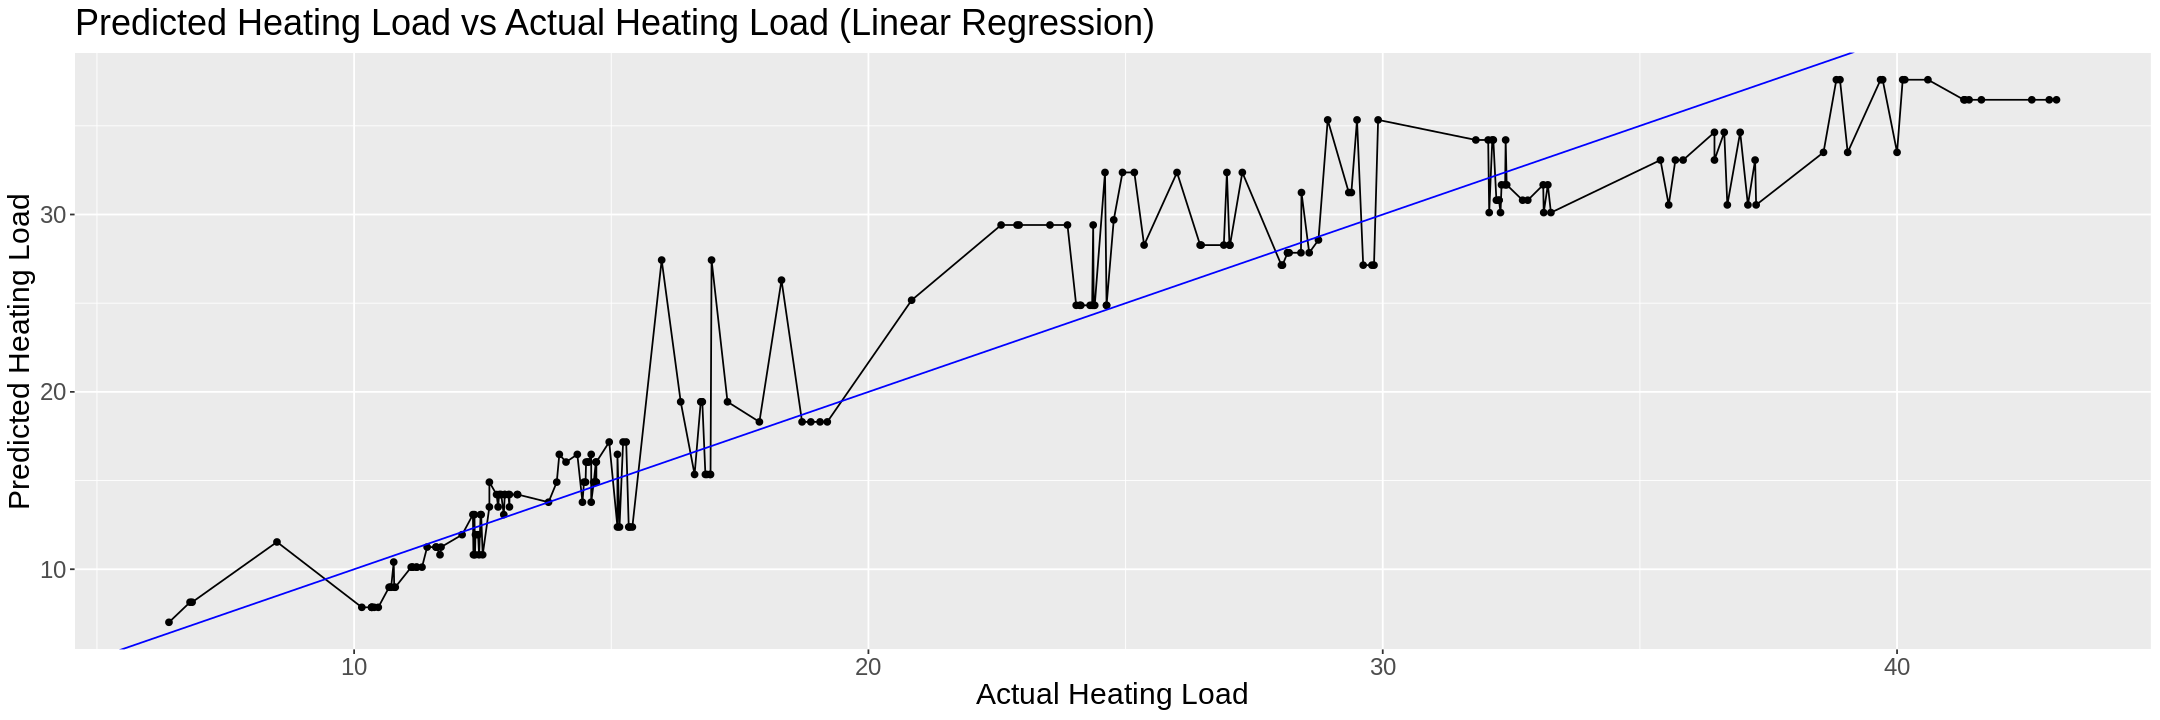

In [25]:
# Visualization of Linear Regression Model
predicted_vs_actual_linear_plot <- lm_predictions |>
    ggplot(aes(x = Heating.Load, y = .pred)) +
    geom_point() +
    geom_line() +
    geom_abline(slope=1, intercept = 0, color = "blue") +
    labs(x = "Actual Heating Load", y = "Predicted Heating Load") +
    ggtitle("Predicted Heating Load vs Actual Heating Load (Linear Regression)") +
    theme(text = element_text(size = 18))
predicted_vs_actual_linear_plot

<div style="color:#999999; text-align: center; font-size:15px; font-family: Arial, sans-serif;">
Figure 4.3.2: Visualization of linear regression results.
</div>

> The blue line is the accuracy line. It represents a perfectly accurate model where the predicted Heating Load is always the same as the true Heating Load. It shows how far off our predicted data is from the true values. A perfect model would align with the blue line exactly.

## 5. Discussion

**5.1. Comparison of K-NN Regression vs Linear Regression**

The RMSPE of K-NN regression is about 0.63, and the RMSPE of linear regression is about 3.13. K-NN regression has smaller RMSPE, so K-NN regression may be the better model for our dataset and analysis. The reason may be that the relationship between Surface Area and Heating Load is not linear (which can be seen from Figure 3.4.1 above), therefore linear regression is not as suitable and accurate as K-NN regression. While the RMSPE may seem small for both K-NN and linear regression, in the context of Heating Load, 3.13 is a large error compared to 0.63. This is further backed up with the visualizations of the accuracies of our models (predicted vs actual Heating Load in figures 4.3.1 and 4.3.2) which shows that the K-NN regression model predicts the Heating Load much more accurately than the linear regression model. The K-NN model follows the accuracy line closely and deviates from it minimally. The linear regression model on the other hand does not follow the line closely, showing its inaccuracies. This shows that for our data, the K-NN regression model may be better suited.

**5.2. Summary of Findings**

We found that for our data, the K-NN regression model predicts the Heating Load of our testing data more accurately than our linear regression model as the linear model's predictions have much more deviation from the true Heating Load compared to the K-NN regression model, however, both K-NN and linear regression models are reasonable. The accuracy visualizations (figure 4.3.1 and 4.3.2) show that both models are more accurate at predicting smaller Heating Loads rather than larger Heating Loads, specifically buildings with a Heating Load approximately less than 15. This can be explained as buildings with larger Heating Loads must also lose more energy which could create more variable results than buildings that contain energy more efficiently. This results in our models being more accurate with predictions of smaller Heating Loads. 

Looking at the formula for linear regression, we can see that Glazing Area is the predictor with the most influence on the Heating Load (as it has the greatest coefficient), followed by Overall Height, and then Surface Area (which has the smallest coefficient). Glazing Area is shown to have a very strong influence on the Heating Load which makes sense as glass is a poor insulator, causing significant energy to escape through them ("Why Glass In Windows Is A Poor Insulator"). More glass means more energy loss which results in a higher Heating Load. Height has a smaller influence on the Heating Load but is still of significant influence. This makes sense because heat rises (since hotter molecules move faster and expand, lowering its density and rising), meaning taller buildings have to be heated more to warm the lower areas. This results in more energy spent overall, and a higher Heating Load. We found that Surface Area does not have a significant influence on the linear regression model. However, this may be because all buildings in our dataset have the same volume and as a result, different surface areas influence the model less than other predictors since the same volume is being heated.

**5.3. Is This What We Expected?**

Our results are mostly what we expected to find, as we expected K-NN to be more effective than linear regression, as well as Glazing Area and Overall Height to have a stronger influence on the Heating Load (when compared to Surface Area). Our initial expectation was that K-NN regression would perform better due to the weak linearity of our visualizations and indeed, as figure 4.1.5 and 4.2.4 show, K-NN regression does have a lower RMSPE than linear regression, showing that it can predict the Heating Load more accurately. Additionally, looking at the linear regression formula, Glazing Area has the most influence on the Heating Load. Overall Height has less of an impact than we expected but it still has a stronger influence than Surface Area, which follows our initial expectations. We expected the influence of Overall Height and Glazing Area to be around the same but Glazing Area has a much stronger influence.

Our findings that Glazing Area and Overall Height are good predictors for Heating Load are also consistent with relevant research. Algerian researchers found that Glazing Area is "responsible for about 25-30% of the heat loss in a building because [it] is a poor insulator" (Djamel & Noureddine) and Korean researchers found that when a building is taller, the "stack effect increases", which leads to amongst other effects, an "increase [in] the building heating load or energy demand" (Song & Kang)

**5.4. What Impact Could Such Findings Have?**

Our findings could help architects determine the Heating Load of future buildings to make energy-efficient design decisions, saving money and mitigating climate change. Furthermore, there are currently tools such as the MIT Design Advisor that help architects design energy-efficient buildings. Our findings may help the developers of such programs to fine tune their algorithms to produce even more energy-efficient designs.

**5.5. What Future Questions Could This Lead To?**

Further research in this topic could look at:
- Does the Cooling Load of the building also have a similar relationship with our predictor variables?
- Do external variables that are not considered (e.g. climate, elevation, humidity) also affect the heating load of a building?

## References

Government of Australia: https://basix.nsw.gov.au/iframe/thermal-help/heating-and-cooling-loads.html#:~:text=The%20heating%20load%20is%20the,temperature%20in%20an%20acceptable%20range

Dataset (Tsanas & Xifara): https://archive.ics.uci.edu/ml/datasets/Energy+efficiency

Tsanas & Xifara: https://doi.org/10.1016/j.enbuild.2012.03.003

Government of Australia: https://basix.nsw.gov.au/iframe/thermal-help/heating-and-cooling-loads.html#:~:text=The%20heating%20load%20is%20the,temperature%20in%20an%20acceptable%20range.  

How to Calculate Heat Load: https://www.plumbersstock.com/how-to-hvac/calculate-heat-load.html

MIT Design Advisor: http://designadvisor.mit.edu/design/

Urban & Glicksman: http://designadvisor.mit.edu/design/papers/urban_glicksman_simbuild_2006.pdf

Definition of relative compactness: https://emupassive.com/2015/10/26/the-compactness-ratio-of-a-building/, http://ibpsa.org/proceedings/BS2011/P_1563.pdf

Definition of Heating and Cooling Load: https://basix.nsw.gov.au/iframe/thermal-help/heating-and-cooling-loads.html#:~:text=The%20heating%20load%20is%20the,temperature%20in%20an%20acceptable%20range

Why Glass In WIndows Is A Poor Insulator: https://www.winsulator-technologies.com/blog/why-glass-windows-are-a-poor-insulator#:~:text=In%20the%20winter%2C%20this%20means,move%20freely%20through%20the%20material.

Song & Kang: http://www.i-asem.org/publication_conf/acem14/1.WAS/T5A.2.MS506_334F.pdf
  
Djamel & Noureddine: https://www.sciencedirect.com/science/article/pii/S1876610217322154?ref=pdf_download&fr=RR-2&rr=7b6fd8e9ed8aec23